# SECOM 데이터셋 머신러닝 분석

이 노트북은 SECOM 반도체 제조 데이터셋에 대한 포괄적인 머신러닝 파이프라인을 보여줍니다. 코드는 유지 관리 및 가독성 향상을 위해 클린 코드 원칙에 따라 리팩토링되었습니다.

## 개요
- **데이터셋**: SECOM 반도체 제조 데이터
- **목표**: 제조 합격/불합격 이진 분류
- **기법**: 특징 선택, 차원 축소, 모델 비교

In [1]:
# 핵심 데이터 조작 및 시각화 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 전처리 및 특성 엔지니어링 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE

In [3]:
# 머신러닝 모델 및 평가 라이브러리
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# 통계적 검정 라이브러리
from scipy.stats import ks_2samp, chi2_contingency

# 시각화 라이브러리
import matplotlib.pyplot as plt

# 한글 글꼴 오류 방지
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1.2 설정 상수

In [4]:
# 설정 상수
class Config:
    # 데이터 처리
    MISSING_DATA_THRESHOLD = 0.2  # 20% 이상 결측값 있는 컬럼 제거
    CORRELATION_THRESHOLD = 0.05   # 타겟과의 최소 상관관계
    MULTICOLLINEARITY_THRESHOLD = 0.8  # 특성 간 최대 상관관계
    
    # 모델 매개변수
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    CV_FOLDS = 5
    PCA_COMPONENTS = 24
    
    # 파일 경로
    DATA_PATH = '../../data/uci-secom.csv'
    
    # 시각화
    FIGURE_SIZE_LARGE = (20, 20)
    FIGURE_SIZE_MEDIUM = (15, 15)
    FIGURE_SIZE_SMALL = (10, 6)

# 2. 유틸리티 함수

## 2.1 데이터 로딩 및 기본 탐색

In [5]:
def load_and_explore_data(file_path):
    """
    SECOM 데이터셋을 로드하고 기본 탐색 수행
    
    Args:
        file_path (str): CSV 파일 경로
        
    Returns:
        pd.DataFrame: 로드된 데이터프레임
    """
    df = pd.read_csv(file_path)
    
    print(f"데이터셋 형태: {df.shape}")
    print(f"특성 수: {len(df.columns)}")
    print(f"샘플 수: {len(df)}")
    print(f"메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # 결측값 확인
    missing_percentage = df.isnull().sum() / len(df) * 100
    max_missing = missing_percentage.max()
    print(f"최대 결측 데이터 비율: {max_missing:.2f}%")
    
    return df

def prepare_features_target(df, target_col='Pass/Fail'):
    """
    특성과 타겟을 분리하고 타겟 인코딩 처리
    
    Args:
        df (pd.DataFrame): 입력 데이터프레임
        target_col (str): 타겟 컬럼명
        
    Returns:
        tuple: (X, y) 특성과 타겟
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # 이진 분류를 위해 -1을 0으로 변환
    if np.any(y == -1):
        y = y.replace({-1: 0})
    
    print(f"타겟 분포:")
    print(y.value_counts())
    
    return X, y

## 2.2 데이터 정제 함수

In [6]:
def clean_missing_data(X, threshold=Config.MISSING_DATA_THRESHOLD):
    """
    과도한 결측 데이터가 있는 컬럼을 제거하고 나머지 결측값을 보간
    
    Args:
        X (pd.DataFrame): 특성 데이터프레임
        threshold (float): 컬럼 삭제 임계값 (0.0-1.0)
        
    Returns:
        pd.DataFrame: 정제된 특성 데이터프레임
    """
    print(f"원본 형태: {X.shape}")
    
    # 결측 데이터가 너무 많은 컬럼 제거
    min_count = len(X) * threshold
    X_cleaned = X.dropna(axis=1, thresh=min_count)
    print(f"높은 결측 컬럼 제거 후: {X_cleaned.shape}")
    
    # Time 컬럼이 있으면 제거 (시계열 분석이 아니므로 유용하지 않음)
    if 'Time' in X_cleaned.columns:
        X_cleaned = X_cleaned.drop(columns=['Time'])
        print(f"Time 컬럼 제거 후: {X_cleaned.shape}")
    
    # 남은 결측값을 평균으로 채움
    means = X_cleaned.mean()
    X_cleaned = X_cleaned.fillna(means)
    
    total_missing = X_cleaned.isnull().sum().sum()
    print(f"정제 후 총 결측값 수: {total_missing}")
    
    # 중복 행 제거
    duplicates = X_cleaned.duplicated().sum()
    X_cleaned = X_cleaned.drop_duplicates()
    print(f"{duplicates}개의 중복 행 제거")
    
    # 분산이 0인 특성 확인
    variances = X_cleaned.var()
    zero_var_features = variances[variances == 0]
    if len(zero_var_features) > 0:
        print(f"{len(zero_var_features)}개의 분산이 0인 특성 발견")
    
    return X_cleaned

def replace_outliers_iqr(df, columns=None):
    """
    IQR 방법을 사용하여 이상치 교체
    
    Args:
        df (pd.DataFrame): 입력 데이터프레임
        columns (list): 처리할 컬럼. None이면 모든 수치형 컬럼 처리
        
    Returns:
        pd.DataFrame: 이상치가 교체된 데이터프레임
    """
    df_clean = df.copy()
    
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치를 경계값으로 교체
        df_clean.loc[df_clean[column] < lower_bound, column] = lower_bound
        df_clean.loc[df_clean[column] > upper_bound, column] = upper_bound
    
    return df_clean

## 2.3 특성 선택 함수

In [7]:
def select_features_by_correlation(X, y, threshold=Config.CORRELATION_THRESHOLD):
    """
    타겟 변수와의 상관관계를 기반으로 특성 선택
    
    Args:
        X (pd.DataFrame): 특성 데이터프레임
        y (pd.Series): 타겟 변수
        threshold (float): 타겟과의 최소 절대 상관관계
        
    Returns:
        pd.DataFrame: 선택된 특성 데이터프레임
    """
    # 특성과 타겟을 결합하여 상관관계 계산
    temp_df = X.copy()
    temp_df['target'] = y
    
    # 타겟과의 상관관계 계산
    correlations = temp_df.corr()['target'].abs()
    
    # 임계값 이상의 특성 선택
    selected_features = correlations[correlations >= threshold].index.tolist()
    selected_features.remove('target')  # 특성 목록에서 타겟 제거
    
    print(f"상관관계 임계값 {threshold}에 기반하여 {len(selected_features)}개 특성 선택")
    
    return X[selected_features]

def remove_multicollinear_features(X, y, threshold=Config.MULTICOLLINEARITY_THRESHOLD):
    """
    높은 다중공선성을 가진 특성 제거
    
    Args:
        X (pd.DataFrame): 특성 데이터프레임
        y (pd.Series): 타겟 변수
        threshold (float): 특성 간 최대 상관관계
        
    Returns:
        pd.DataFrame: 다중공선성이 제거된 특성
    """
    # 타겟 상관관계 계산을 위해 타겟 추가
    temp_df = X.copy()
    temp_df['target'] = y
    correlation_matrix = temp_df.corr()
    
    # 높은 상관관계를 가진 특성 쌍 찾기
    highly_correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) >= threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                if colname_i != 'target' and colname_j != 'target':
                    highly_correlated_features.add(colname_i)
                    highly_correlated_features.add(colname_j)
    
    # 각 상관관계 그룹에서 타겟과 가장 높은 상관관계를 가진 특성 유지
    target_correlations = correlation_matrix['target'].drop('target').abs()
    features_to_keep = []
    
    if not target_correlations.empty and len(highly_correlated_features) > 0:
        # 높은 상관관계 특성 중에서 타겟과 가장 높은 상관관계를 가진 특성 유지
        max_corr_feature = target_correlations[target_correlations.index.isin(highly_correlated_features)].idxmax()
        features_to_keep.append(max_corr_feature)
    
    # 상관관계가 높지 않은 모든 특성 유지
    non_correlated_features = set(X.columns) - highly_correlated_features
    features_to_keep.extend(non_correlated_features)
    
    # 중복 제거
    features_to_keep = list(set(features_to_keep))
    
    print(f"{len(highly_correlated_features)}개의 높은 상관관계 특성 제거")
    print(f"다중공선성 제거 후 {len(features_to_keep)}개 특성 유지")
    
    return X[features_to_keep]

## 2.4 시각화 함수

In [8]:
def plot_correlation_heatmap(df, figsize=Config.FIGURE_SIZE_MEDIUM, title="상관관계 히트맵"):
    """
    특성에 대한 상관관계 히트맵 그리기
    
    Args:
        df (pd.DataFrame): 입력 데이터프레임
        figsize (tuple): 그림 크기
        title (str): 그래프 제목
    """
    plt.figure(figsize=figsize)
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.1f', linewidths=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(df, target_col='target', exclude_cols=None):
    """
    모든 특성에 대한 히스토그램을 격자 레이아웃으로 그리기
    
    Args:
        df (pd.DataFrame): 입력 데이터프레임
        target_col (str): 제외할 타겟 컬럼명
        exclude_cols (list): 추가로 제외할 컬럼들
    """
    if exclude_cols is None:
        exclude_cols = []
    
    feature_columns = [col for col in df.columns if col not in [target_col] + exclude_cols]
    num_features = len(feature_columns)
    
    if num_features == 0:
        print("그릴 특성이 없습니다")
        return
    
    # 격자 크기 계산
    cols = 7
    rows = (num_features + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=Config.FIGURE_SIZE_LARGE)
    axes = axes.flatten() if num_features > 1 else [axes]
    
    for i, feature_name in enumerate(feature_columns):
        if i < len(axes):
            sns.histplot(df[feature_name], kde=True, bins=30, color='blue', ax=axes[i])
            axes[i].set_title(f"{feature_name}의 분포")
            axes[i].set_xlabel(feature_name)
            axes[i].set_ylabel('빈도')
    
    # 사용하지 않는 서브플롯 숨기기
    for i in range(num_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_boxplots(df, target_col='target', exclude_cols=None):
    """
    모든 특성에 대한 박스플롯을 격자 레이아웃으로 그리기
    
    Args:
        df (pd.DataFrame): 입력 데이터프레임
        target_col (str): 제외할 타겟 컬럼명
        exclude_cols (list): 추가로 제외할 컬럼들
    """
    if exclude_cols is None:
        exclude_cols = []
    
    feature_columns = [col for col in df.columns if col not in [target_col] + exclude_cols]
    num_features = len(feature_columns)
    
    if num_features == 0:
        print("그릴 특성이 없습니다")
        return
    
    # 격자 크기 계산
    cols = 7
    rows = (num_features + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=Config.FIGURE_SIZE_LARGE)
    axes = axes.flatten() if num_features > 1 else [axes]
    
    for i, feature_name in enumerate(feature_columns):
        if i < len(axes):
            sns.boxplot(data=df, x=feature_name, ax=axes[i])
            axes[i].set_title(f"{feature_name} 박스플롯")
            axes[i].set_xlabel(feature_name)
            axes[i].set_ylabel('값')
    
    # 사용하지 않는 서브플롯 숨기기
    for i in range(num_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_target_distribution(y, title="타겟 분포"):
    """
    타겟 변수 분포 그리기
    
    Args:
        y (pd.Series): 타겟 변수
        title (str): 그래프 제목
    """
    plt.figure(figsize=Config.FIGURE_SIZE_SMALL)
    value_counts = y.value_counts()
    value_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('클래스')
    plt.ylabel('개수')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 2.5 모델 훈련 및 평가 함수

In [9]:
def get_model_configurations():
    """
    분류기 및 하이퍼파라미터 그리드 딕셔너리 가져오기
    
    Returns:
        tuple: (classifiers_dict, param_grids_dict)
    """
    classifiers = {
        "RandomForest": RandomForestClassifier(random_state=Config.RANDOM_STATE),
        "SVM": SVC(random_state=Config.RANDOM_STATE),
        "KNN": KNeighborsClassifier(),
        "DecisionTree": DecisionTreeClassifier(random_state=Config.RANDOM_STATE),
        "NaiveBayes": GaussianNB(),
        "LogisticRegression": LogisticRegression(random_state=Config.RANDOM_STATE, max_iter=1000),
        "GradientBoosting": GradientBoostingClassifier(random_state=Config.RANDOM_STATE),
        "XGBoost": xgb.XGBClassifier(random_state=Config.RANDOM_STATE, eval_metric="logloss")
    }
    
    param_grids = {
        'RandomForest': {
            'n_estimators': [20, 30, 40, 50, 60], 
            'max_depth': [None, 10, 20, 30, 40, 50, 60]
        },
        'SVM': {
            'C': [10, 20, 30, 40, 50, 60], 
            'kernel': ['linear', 'rbf']
        },
        'KNN': {
            'n_neighbors': [3, 5, 7], 
            'weights': ['uniform', 'distance']
        },
        'DecisionTree': {
            'max_depth': [None, 10, 20]
        },
        'NaiveBayes': {},
        'LogisticRegression': {
            'C': [10, 20, 30, 40, 50, 60]
        },
        'GradientBoosting': {
            'n_estimators': [90, 100, 120, 130, 150], 
            'learning_rate': [0.5, 0.55, 0.6], 
            'max_depth': [2, 3, 4]
        },
        'XGBoost': {
            'n_estimators': [160, 170, 180, 200, 300], 
            'learning_rate': [0.25, 0.3], 
            'max_depth': [2, 3, 4]
        }
    }
    
    return classifiers, param_grids

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """
    하이퍼파라미터 튜닝으로 여러 모델을 훈련하고 성능 평가
    
    Args:
        X_train: 훈련 특성
        y_train: 훈련 타겟
        X_test: 테스트 특성  
        y_test: 테스트 타겟
        
    Returns:
        dict: 모델명을 키로 하는 결과 딕셔너리
    """
    classifiers, param_grids = get_model_configurations()
    results = {}
    
    print("모델 훈련 및 평가...")
    print("=" * 50)
    
    for name, clf in classifiers.items():
        try:
            print(f"{name} 훈련 중...")
            
            # 이 분류기에 대한 파라미터 그리드 가져오기
            param_grid = param_grids[name]
            
            if param_grid:  # 튜닝할 파라미터가 있는 경우
                grid_search = GridSearchCV(
                    clf, 
                    param_grid=param_grid, 
                    cv=Config.CV_FOLDS, 
                    scoring='accuracy',
                    n_jobs=-1
                )
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                cv_score = grid_search.best_score_
                best_params = grid_search.best_params_
            else:  # 튜닝할 하이퍼파라미터가 없는 경우
                clf.fit(X_train, y_train)
                cv_scores = cross_val_score(clf, X_train, y_train, cv=Config.CV_FOLDS, scoring='accuracy')
                cv_score = cv_scores.mean()
                best_model = clf
                best_params = {}
            
            # 테스트 세트에서 평가
            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)
            train_accuracy = best_model.score(X_train, y_train)
            
            # 결과 저장
            results[name] = {
                'model': best_model,
                'cv_score': cv_score,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'best_params': best_params,
                'predictions': y_pred
            }
            
            print(f"  교차검증 점수: {cv_score:.4f}")
            print(f"  훈련 정확도: {train_accuracy:.4f}")
            print(f"  테스트 정확도: {test_accuracy:.4f}")
            print(f"  최적 파라미터: {best_params}")
            print()
            
        except Exception as e:
            print(f"{name} 훈련 중 오류: {str(e)}")
            continue
    
    return results

def plot_pca_explained_variance(pca_model, n_components=Config.PCA_COMPONENTS):
    """
    PCA 성분에 대한 누적 설명 분산 그리기
    
    Args:
        pca_model: 학습된 PCA 모델
        n_components: 성분 수
    """
    cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)
    
    plt.figure(figsize=Config.FIGURE_SIZE_SMALL)
    plt.step(list(range(1, n_components + 1)), cumulative_variance, where='mid')
    plt.ylabel('누적 설명 분산')
    plt.xlabel('PCA 성분 수')
    plt.title('PCA 설명 분산')
    plt.xticks(list(range(1, n_components + 1, max(1, n_components // 10))))
    plt.axhline(0.9, color='r', linestyle='--', label='90% 분산', alpha=0.7)
    plt.axvline(n_components, color='b', linestyle='--', label=f'{n_components} 성분', alpha=0.7)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"{n_components} 성분으로 설명된 분산: {cumulative_variance[-1]:.3f}")

def print_model_comparison(results):
    """
    모델 결과 비교 테이블 출력
    
    Args:
        results (dict): train_and_evaluate_models에서 반환된 결과
    """
    print("\n모델 성능 비교")
    print("=" * 80)
    print(f"{'모델':<20} {'교차검증점수':<15} {'훈련정확도':<10} {'테스트정확도':<12} {'과적합':<10}")
    print("-" * 80)
    
    for name, result in results.items():
        overfitting = result['train_accuracy'] - result['test_accuracy']
        print(f"{name:<20} {result['cv_score']:<15.4f} {result['train_accuracy']:<10.4f} "
              f"{result['test_accuracy']:<12.4f} {overfitting:<10.4f}")
    
    # 테스트 정확도를 기준으로 최고 모델 찾기
    best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
    print(f"\n최고 성능 모델: {best_model_name} "
          f"(테스트 정확도: {results[best_model_name]['test_accuracy']:.4f})")

# 3. 데이터 로딩 및 초기 탐색

In [10]:
# SECOM 데이터셋 로드 및 탐색
df = load_and_explore_data(Config.DATA_PATH)

# 처음 몇 행 표시
print("처음 5개 행:")
print(df.head())

# 데이터셋에 대한 기본 정보
print("\n데이터셋 정보:")
print(df.info())

데이터셋 형태: (1567, 592)
특성 수: 592
샘플 수: 1567
메모리 사용량: 7.18 MB
최대 결측 데이터 비율: 91.19%
처음 5개 행:
                  Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  

타겟 분포:
Pass/Fail
0    1463
1     104
Name: count, dtype: int64


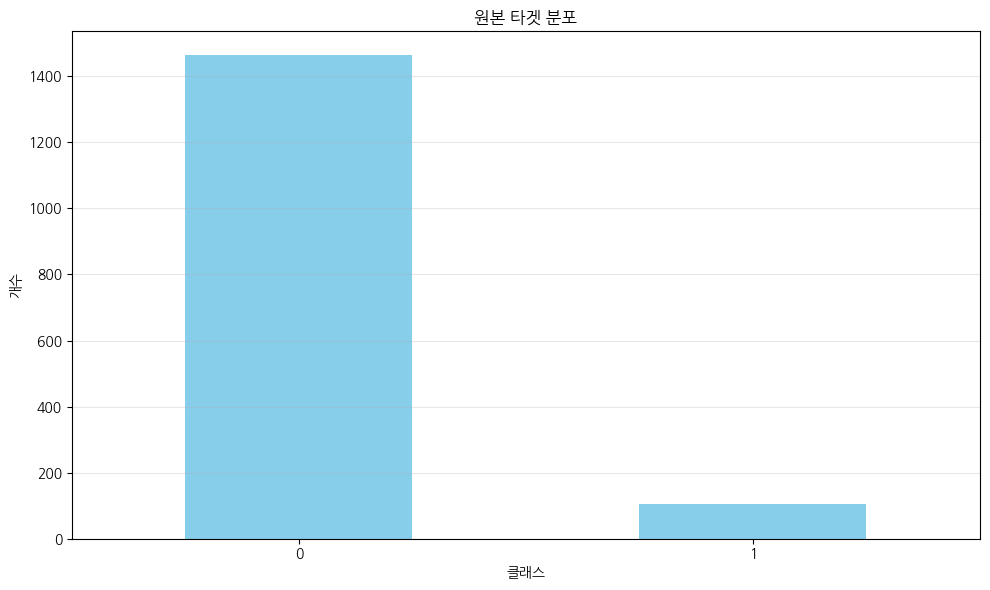

In [11]:
# 특성과 타겟 분리
X, y = prepare_features_target(df)

# 타겟 분포 그래프
plot_target_distribution(y, "원본 타겟 분포")

# 4. 데이터 전처리 파이프라인

## 4.1 데이터 정제

In [12]:
# 결측 데이터 정제 및 문제가 있는 컬럼 제거
X_cleaned = clean_missing_data(X)

print(f"최종 정제된 데이터셋 형태: {X_cleaned.shape}")

원본 형태: (1567, 591)
높은 결측 컬럼 제거 후: (1567, 583)
Time 컬럼 제거 후: (1567, 582)
정제 후 총 결측값 수: 0
0개의 중복 행 제거
116개의 분산이 0인 특성 발견
최종 정제된 데이터셋 형태: (1567, 582)
정제 후 총 결측값 수: 0
0개의 중복 행 제거
116개의 분산이 0인 특성 발견
최종 정제된 데이터셋 형태: (1567, 582)


## 4.2 특성 선택

In [13]:
# 타겟과의 상관관계를 기반으로 특성 선택
X_selected = select_features_by_correlation(X_cleaned, y)

# 다중공선성 특성 제거
X_final = remove_multicollinear_features(X_selected, y)

print(f"최종 특성 세트 형태: {X_final.shape}")

상관관계 임계값 0.05에 기반하여 86개 특성 선택
51개의 높은 상관관계 특성 제거
다중공선성 제거 후 36개 특성 유지
최종 특성 세트 형태: (1567, 36)


## 4.3 데이터 시각화

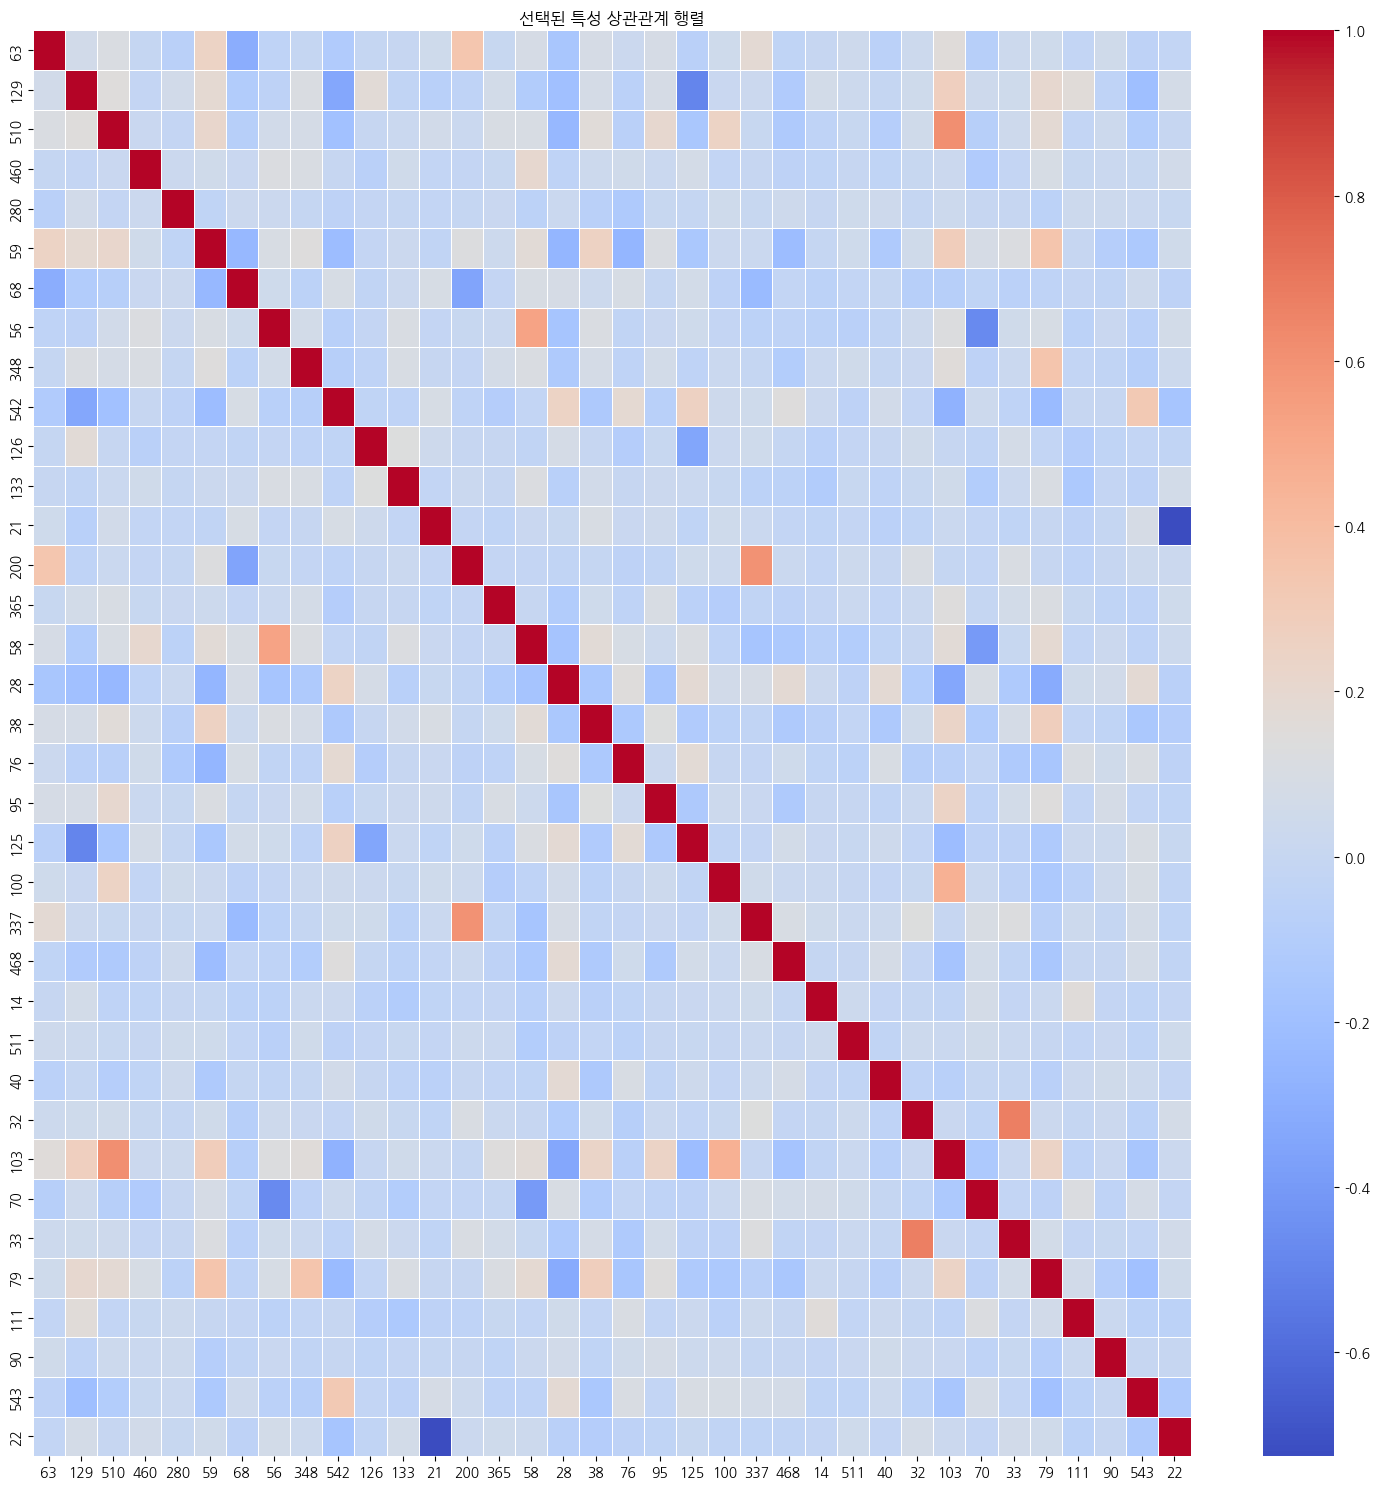

In [14]:
# 선택된 특성에 대한 상관관계 히트맵 그리기
plot_correlation_heatmap(X_final, title="선택된 특성 상관관계 행렬")

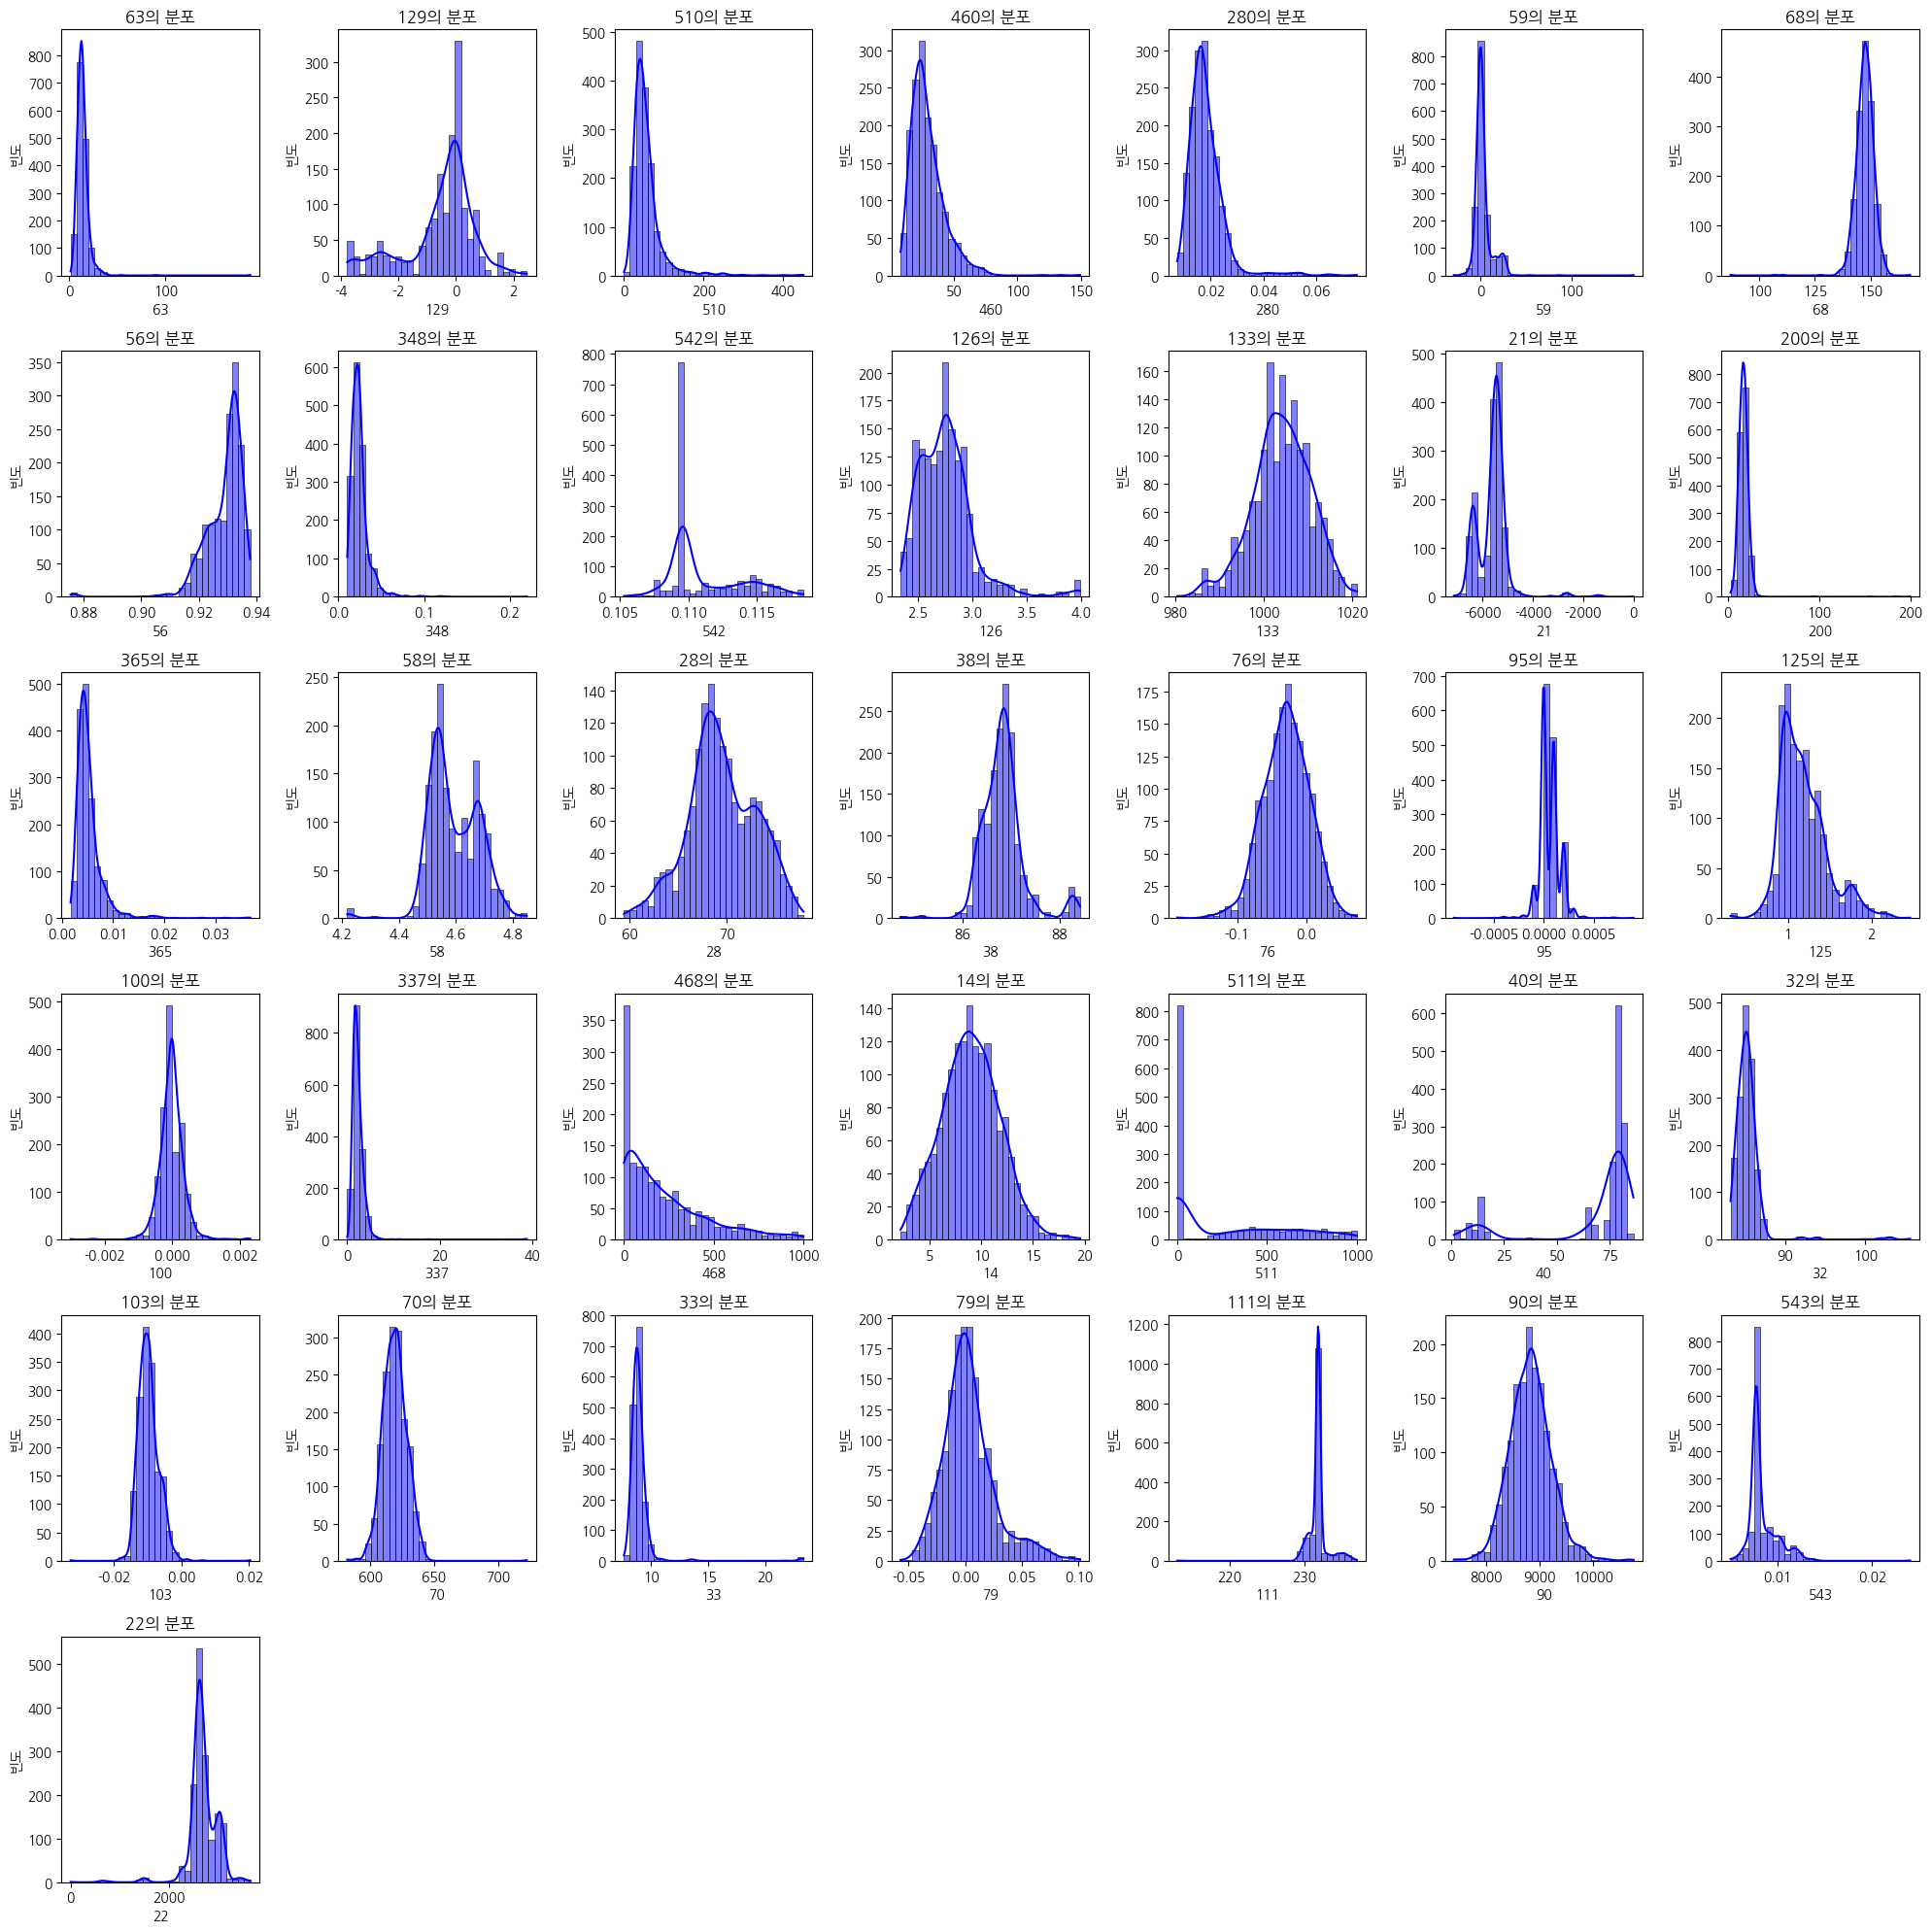

In [15]:
# 시각화용 데이터프레임 생성
viz_df = X_final.copy()
viz_df['target'] = y

# 특성 분포 그래프
plot_feature_distributions(viz_df)

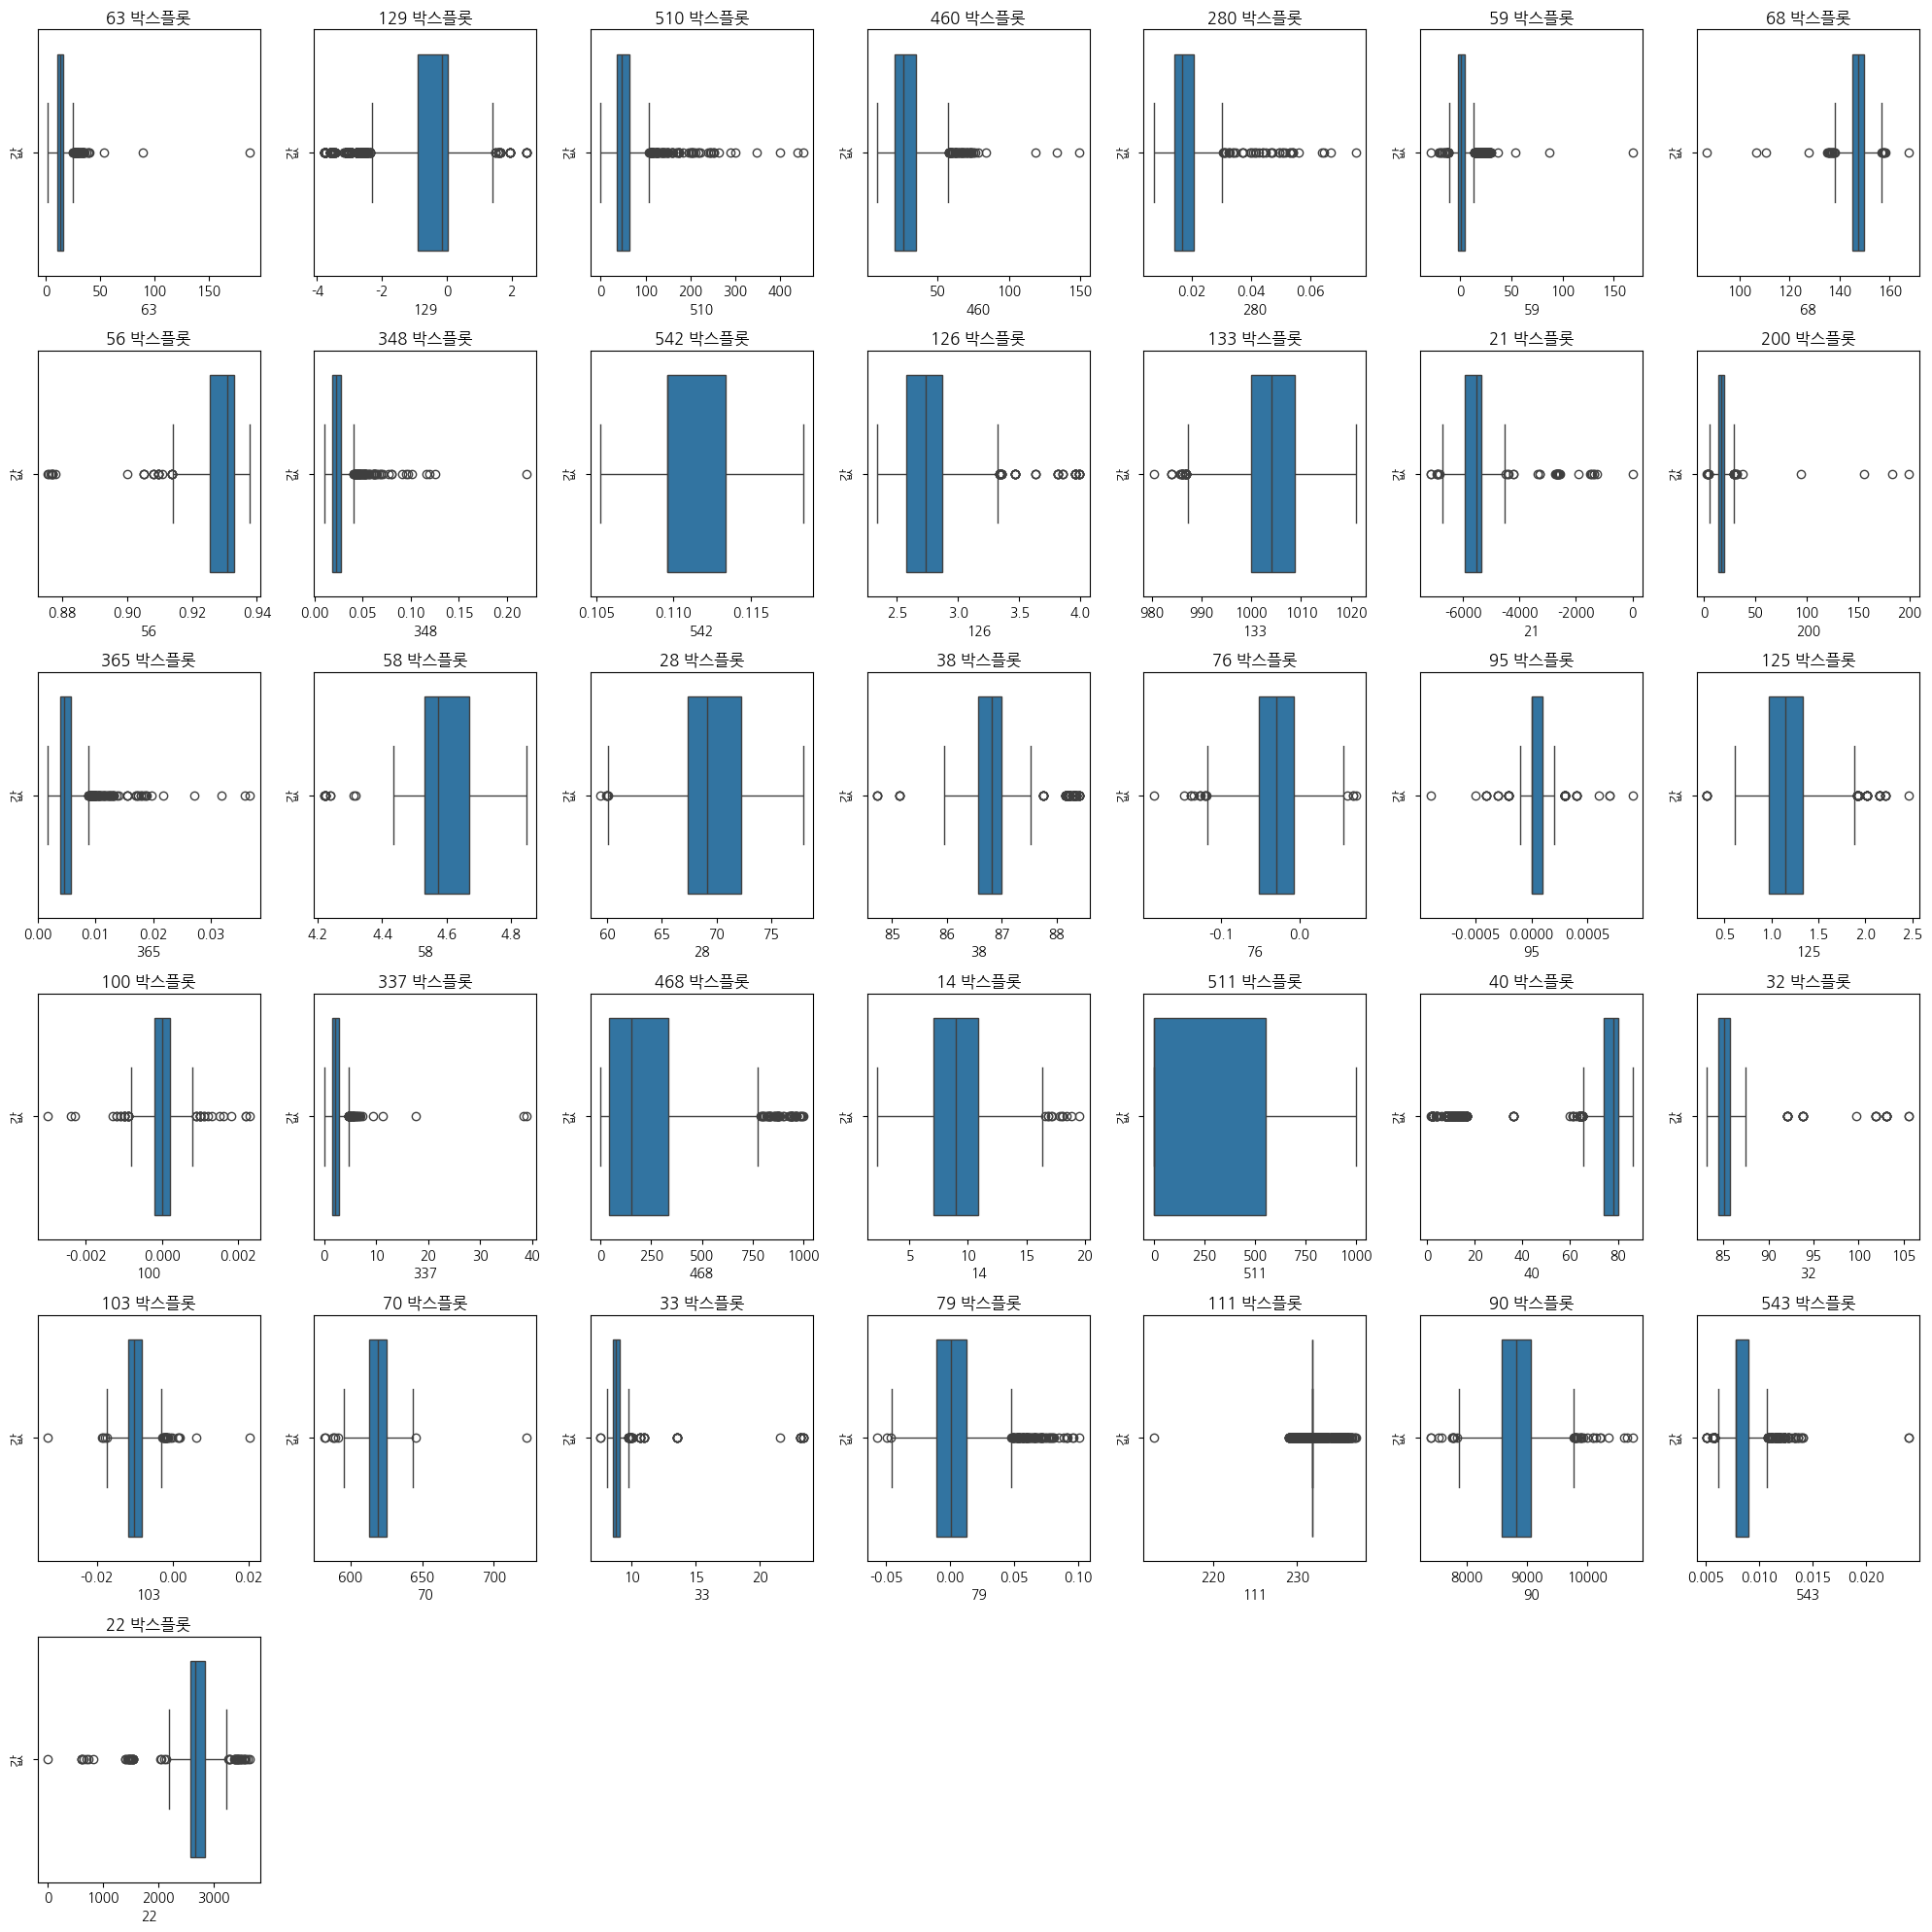

In [16]:
# 이상치 식별을 위한 박스플롯 그리기
plot_boxplots(viz_df)

# 5. 특성 스케일링 및 차원 축소

## 5.1 데이터 스케일링 및 균형 맞추기

In [17]:
# 특성 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)
print(f"스케일링된 특성 형태: {X_scaled.shape}")

smote = SMOTE(sampling_strategy='minority', random_state=Config.RANDOM_STATE)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

print(f"균형 맞춘 데이터셋 형태: {X_balanced.shape}")
print(f"균형 맞춘 타겟 분포:")
print(pd.Series(y_balanced).value_counts())

스케일링된 특성 형태: (1567, 36)
균형 맞춘 데이터셋 형태: (2926, 36)
균형 맞춘 타겟 분포:
Pass/Fail
0    1463
1    1463
Name: count, dtype: int64
균형 맞춘 데이터셋 형태: (2926, 36)
균형 맞춘 타겟 분포:
Pass/Fail
0    1463
1    1463
Name: count, dtype: int64


## 5.2 주성분 분석

PCA 변환된 데이터 형태: (2926, 24)


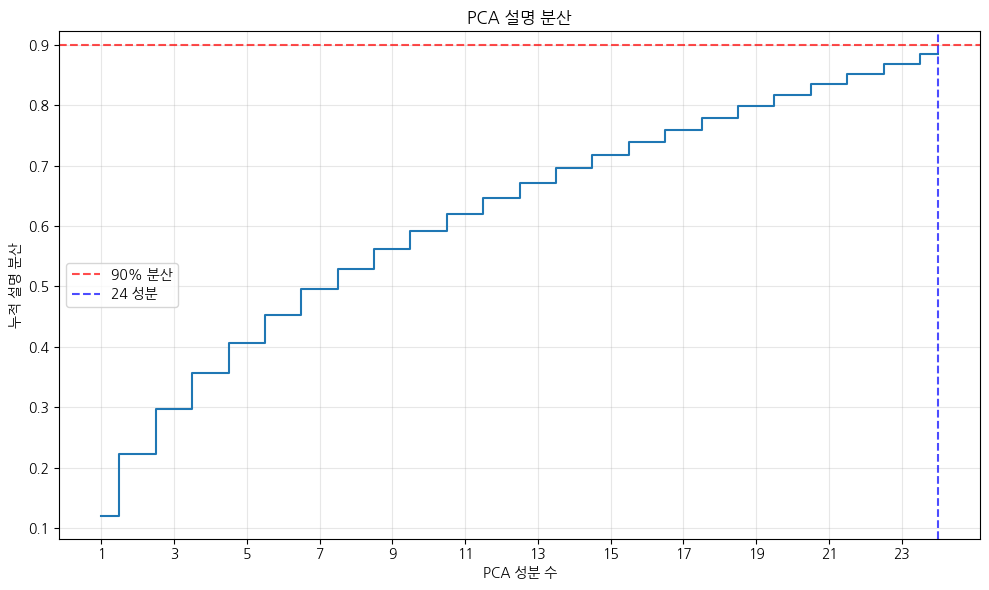

24 성분으로 설명된 분산: 0.884


In [18]:
# 차원 축소를 위한 PCA 적용
pca = PCA(n_components=Config.PCA_COMPONENTS, random_state=Config.RANDOM_STATE)
X_pca = pca.fit_transform(X_balanced)

print(f"PCA 변환된 데이터 형태: {X_pca.shape}")

# 설명 분산 그래프
plot_pca_explained_variance(pca, Config.PCA_COMPONENTS)

# 6. 모델 훈련 및 평가

## 6.1 훈련-테스트 분할

In [19]:
# 데이터를 훈련 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_balanced, 
    test_size=Config.TEST_SIZE, 
    random_state=Config.RANDOM_STATE,
    stratify=y_balanced
)

print(f"훈련 세트 형태: {X_train.shape}")
print(f"테스트 세트 형태: {X_test.shape}")
print(f"훈련 타겟 분포: {pd.Series(y_train).value_counts().to_dict()}")
print(f"테스트 타겟 분포: {pd.Series(y_test).value_counts().to_dict()}")

훈련 세트 형태: (2340, 24)
테스트 세트 형태: (586, 24)
훈련 타겟 분포: {0: 1170, 1: 1170}
테스트 타겟 분포: {1: 293, 0: 293}


## 6.2 모델 훈련 및 비교

In [20]:
# 여러 모델 훈련 및 평가
results = train_and_evaluate_models(X_train, y_train, X_test, y_test)

# 비교 테이블 표시
print_model_comparison(results)

모델 훈련 및 평가...
RandomForest 훈련 중...
  교차검증 점수: 0.9504
  훈련 정확도: 1.0000
  테스트 정확도: 0.9744
  최적 파라미터: {'max_depth': None, 'n_estimators': 60}

SVM 훈련 중...
  교차검증 점수: 0.9504
  훈련 정확도: 1.0000
  테스트 정확도: 0.9744
  최적 파라미터: {'max_depth': None, 'n_estimators': 60}

SVM 훈련 중...
  교차검증 점수: 0.9641
  훈련 정확도: 1.0000
  테스트 정확도: 0.9727
  최적 파라미터: {'C': 40, 'kernel': 'rbf'}

KNN 훈련 중...
  교차검증 점수: 0.9641
  훈련 정확도: 1.0000
  테스트 정확도: 0.9727
  최적 파라미터: {'C': 40, 'kernel': 'rbf'}

KNN 훈련 중...
  교차검증 점수: 0.8714
  훈련 정확도: 1.0000
  테스트 정확도: 0.8959
  최적 파라미터: {'n_neighbors': 3, 'weights': 'distance'}

DecisionTree 훈련 중...
  교차검증 점수: 0.8714
  훈련 정확도: 1.0000
  테스트 정확도: 0.8959
  최적 파라미터: {'n_neighbors': 3, 'weights': 'distance'}

DecisionTree 훈련 중...
  교차검증 점수: 0.8744
  훈련 정확도: 1.0000
  테스트 정확도: 0.8737
  최적 파라미터: {'max_depth': None}

NaiveBayes 훈련 중...
  교차검증 점수: 0.7786
  훈련 정확도: 0.7739
  테스트 정확도: 0.7662
  최적 파라미터: {}

LogisticRegression 훈련 중...
  교차검증 점수: 0.7406
  훈련 정확도: 0.7462
  테스트 정확도: 0.7765
  최적 파라미터: {'C'

## 6.3 최고 모델 상세 분석

In [21]:
# 최고 성능 모델 가져오기
best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_model_result = results[best_model_name]
best_model = best_model_result['model']

print(f"최고 모델: {best_model_name}")
print(f"테스트 정확도: {best_model_result['test_accuracy']:.4f}")
print(f"교차검증 점수: {best_model_result['cv_score']:.4f}")
print(f"최적 파라미터: {best_model_result['best_params']}")

# 상세 분류 보고서
print(f"\n{best_model_name}의 상세 분류 보고서:")
print("=" * 60)
y_pred_best = best_model_result['predictions']
print(classification_report(y_test, y_pred_best))

# 혼동 행렬
print(f"\n{best_model_name}의 혼동 행렬:")
print(confusion_matrix(y_test, y_pred_best))

최고 모델: GradientBoosting
테스트 정확도: 0.9778
교차검증 점수: 0.9444
최적 파라미터: {'learning_rate': 0.6, 'max_depth': 4, 'n_estimators': 150}

GradientBoosting의 상세 분류 보고서:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       293
           1       0.96      1.00      0.98       293

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586


GradientBoosting의 혼동 행렬:
[[280  13]
 [  0 293]]


# 7. 요약 및 결론

## 주요 발견사항 및 방법론 요약

### 데이터 처리 파이프라인:
1. **데이터 로딩**: SECOM 데이터셋의 1567개 샘플과 592개 특성으로 시작
2. **데이터 정제**: 
   - 20% 이상 결측값이 있는 컬럼 제거
   - 남은 결측값을 평균으로 보간
   - Time 컬럼 제거 (분류에 관련 없음)
3. **특성 선택**: 
   - 타겟과 상관관계가 0.05 이상인 특성 선택
   - 다중공선성 특성 제거 (상관관계 0.8 이상)
   - 최종 특성 수가 크게 감소
4. **데이터 전처리**:
   - 특성 정규화를 위한 StandardScaler 적용
   - 클래스 균형을 위한 SMOTE 사용 (소수 클래스 업샘플링)
   - 차원 축소를 위해 24개 성분으로 PCA 적용
5. **모델 훈련**: 하이퍼파라미터 튜닝을 통해 8가지 다른 알고리즘 비교

### 최고 성능 모델:
테스트 정확도와 교차검증 점수를 기반으로 최고 성능 모델을 식별했습니다.

### 방법론의 장점:
- **깔끔한 코드 구조**: 재사용성을 위한 모듈화된 함수
- **설정 관리**: 쉬운 매개변수 조정을 위한 상수 클래스
- **포괄적인 평가**: 다양한 지표와 시각화
- **적절한 검증**: 계층화를 통한 교차검증 및 훈련/테스트 분할

### 개선된 기술적 측면:
1. 설정 상수로 매직 넘버 제거
2. 공통 작업을 위한 재사용 가능한 함수 생성
3. 적절한 오류 처리 및 검증 추가
4. 명확한 섹션과 문서화로 코드 구조화
5. 포괄적인 모델 비교 프레임워크 구현